In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from matplotlib import pyplot as plt

In [2]:
production_chain_df = pd.read_csv("/tmp/production_chain.log", sep="\t", header=None)

In [3]:
production_chain_df.shape

(28, 28)

In [4]:
columns = ["agent"] + list(map(lambda x: str(x), range(production_chain_df.shape[0])))
agent_goods_df = pd.read_csv("/tmp/agent_goods.log", sep="\t", header=None, names=columns)

In [5]:
agent_goods_df

,agent,0,1,2,3,4,5,6,7,8,...,18,19,20,21,22,23,24,25,26,27
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Transactions

In [6]:
columns = ["tick", "seller", "buyer", "product", "amount", "price"]
transaction_df = pd.read_csv("/tmp/transactions.log", sep="\t", header=None, names=columns)

In [7]:
transaction_df["value"] = transaction_df["amount"] * transaction_df["price"]

In [8]:
transaction_df

,tick,seller,buyer,product,amount,price,value
0,0,3,8,3,54.0,20.125944,1086.800969
1,0,2,7,2,123.0,12.223178,1503.450858
2,0,0,5,0,97.0,7.081092,686.865888
3,0,1,6,1,69.0,10.524133,726.165205
4,0,4,9,4,61.0,8.833428,538.839080
...,...,...,...,...,...,...,...
613407,199996,2,7,2,37675.0,9.827796,370262.200643
613408,199998,18,27,18,183.0,2025.871434,370734.472383
613409,199998,15,18,15,1572.0,235.814208,370699.935460
613410,199998,6,15,6,15669.0,23.657506,370689.458079


Text(0.5, 1.0, 'transaction count by tick')

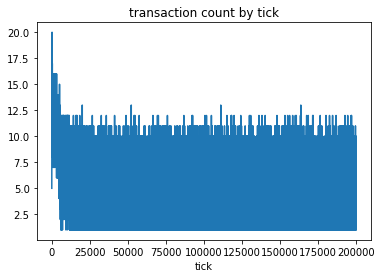

In [9]:
transaction_df.groupby("tick")["price"].count().plot()
plt.title("transaction count by tick")

Text(0.5, 1.0, 'product 0 transaction count per tick')

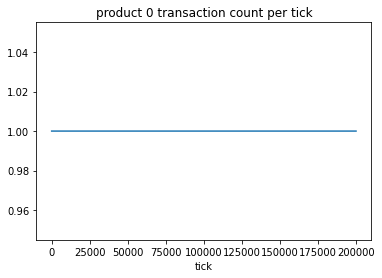

In [10]:
transaction_df[transaction_df["product"] == 0].groupby("tick")["price"].count().plot()
plt.title("product 0 transaction count per tick")

Text(0.5, 1.0, 'transaction unit quantity per tick')

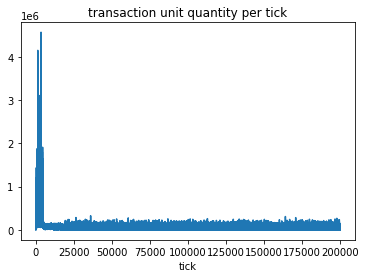

In [11]:
transaction_df.groupby("tick")["amount"].sum().plot()
plt.title("transaction unit quantity per tick")

Text(0.5, 1.0, 'transaction value per tick')

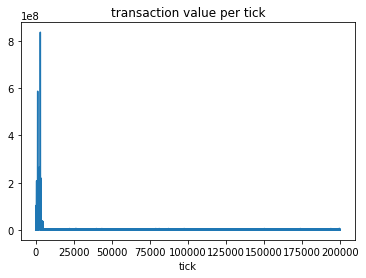

In [12]:
transaction_df.groupby("tick")["value"].sum().plot()
plt.title("transaction value per tick")

<AxesSubplot:xlabel='tick'>

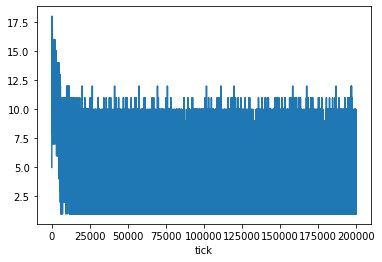

In [13]:
transaction_df.groupby("tick")["product"].nunique().plot()

<AxesSubplot:xlabel='tick'>

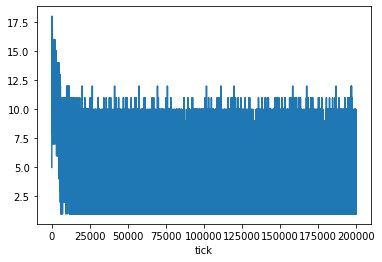

In [14]:
transaction_df.groupby("tick")["seller"].nunique().plot()

<AxesSubplot:xlabel='tick'>

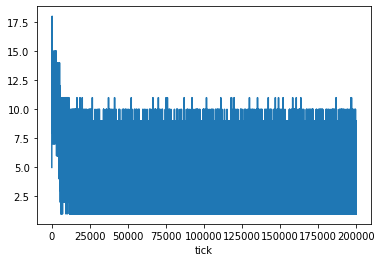

In [15]:
transaction_df.groupby("tick")["buyer"].nunique().plot()

In [16]:
transaction_df["seller"].nunique()

25

In [17]:
transaction_df["buyer"].nunique()

23

In [18]:
transaction_df["product"].nunique()

25

<AxesSubplot:>

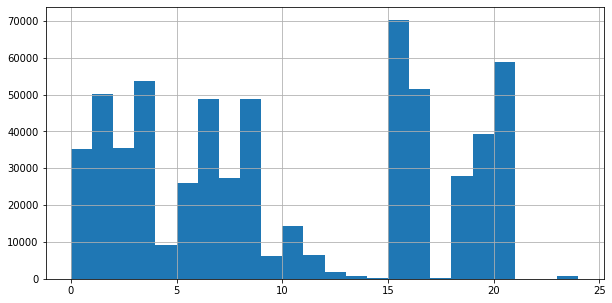

In [19]:
plt.figure(figsize=(10,5))
transaction_df["product"].hist(bins=transaction_df["product"].max())

<AxesSubplot:xlabel='tick'>

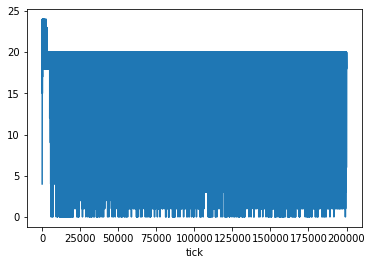

In [20]:
transaction_df.groupby("tick")["product"].max().plot()

In [21]:
transaction_df[transaction_df["seller"] == 3]["price"].describe()

count    53652.000000
mean        17.328494
std          4.378912
min         10.061863
25%         13.425696
50%         17.220939
75%         21.215025
max         24.908074
Name: price, dtype: float64

<AxesSubplot:>

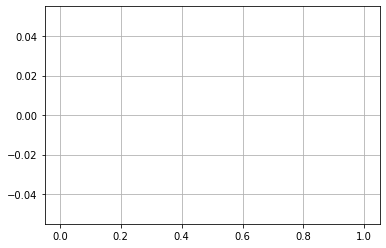

In [22]:
transaction_df[transaction_df["buyer"] == 3]["price"].hist()

## Transaction Graph

In [23]:
G = nx.from_pandas_edgelist(transaction_df, source="seller", target="buyer", create_using=nx.DiGraph)

In [24]:
labels = pd.DataFrame(transaction_df.groupby("seller")["product"].first()).apply(lambda x: f'{x.name}:{x["product"]}', axis=1)

In [25]:
G = nx.relabel_nodes(G, labels)

In [26]:
nx.is_directed_acyclic_graph(G)

True

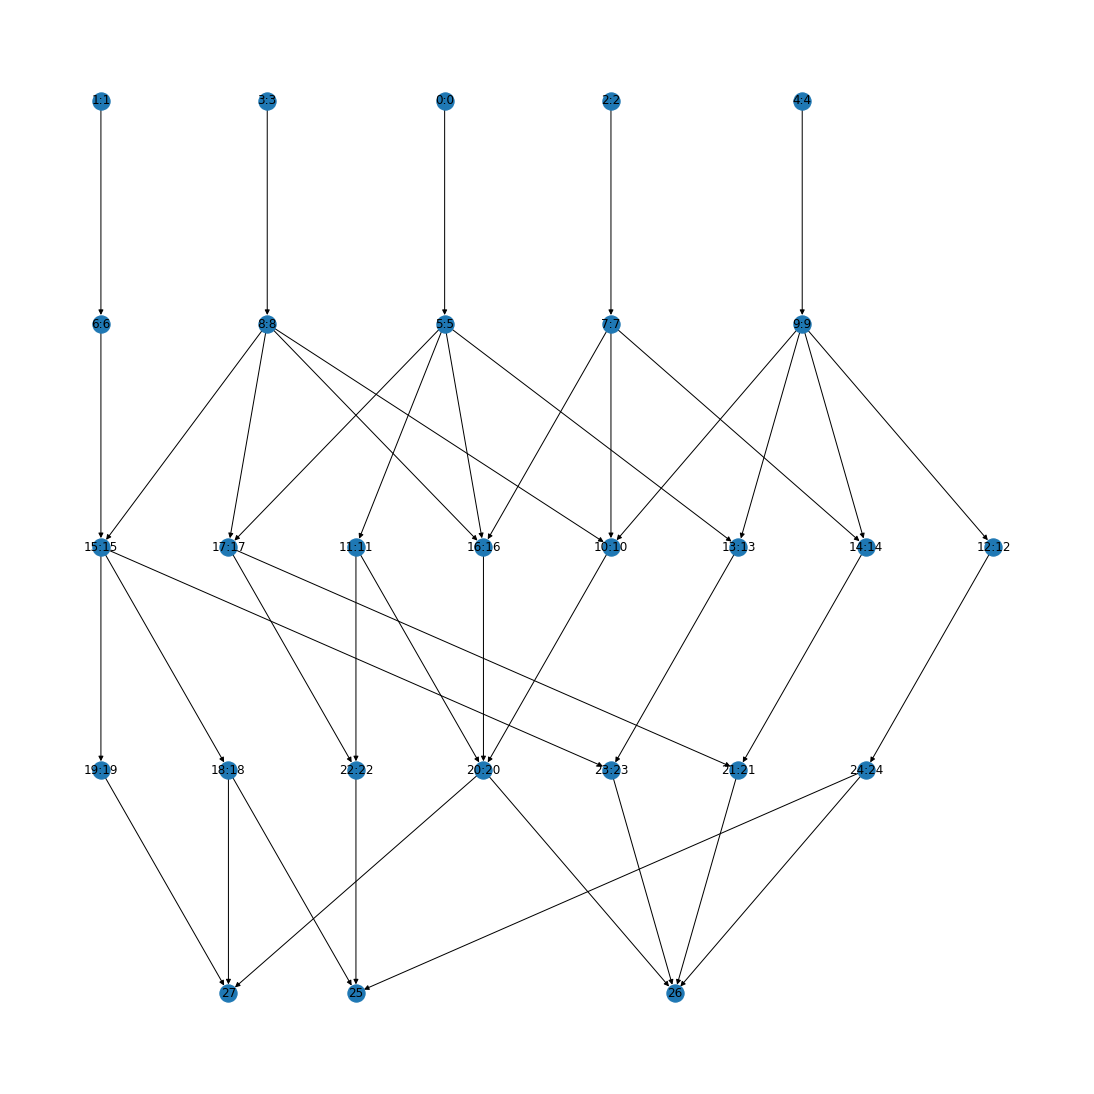

In [27]:
plt.figure(figsize=(15, 15))
#nx.draw_kamada_kawai(G, arrows=True)
pos = graphviz_layout(G, prog='dot')
nx.draw(G, pos, with_labels=True, arrows=True)
plt.show()

# Balance

In [28]:
columns = ["tick", "agent", "balance"]
balance_df = pd.read_csv("/tmp/balance.log", sep="\t", header=None, names=columns)

<AxesSubplot:xlabel='tick'>

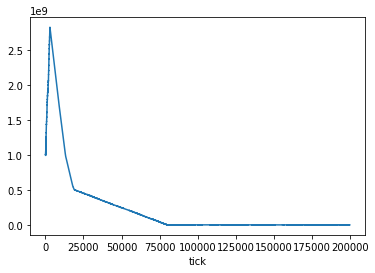

In [29]:
balance_df.groupby("tick")["balance"].sum().plot()

In [30]:
balance_df[balance_df["tick"] == balance_df["tick"].min()]["balance"].describe()

count    2.800000e+01
mean     3.587934e+07
std      1.709378e+08
min      1.313411e+01
25%      8.175257e+02
50%      2.207500e+04
75%      1.237125e+05
max      9.039542e+08
Name: balance, dtype: float64

In [31]:
balance_df[balance_df["tick"] == balance_df["tick"].max()]["balance"].describe()

count        28.000000
mean      37847.108561
std      103151.893920
min           0.836537
25%           4.522265
50%          14.305596
75%         155.484341
max      387584.253370
Name: balance, dtype: float64

In [32]:
ltb_df = balance_df[balance_df["tick"] == balance_df["tick"].max()]

<BarContainer object of 28 artists>

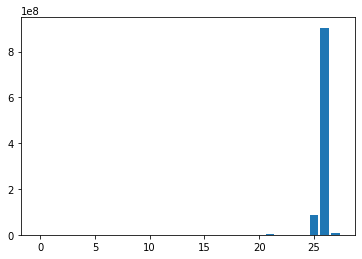

In [33]:
plt.bar(balance_df[balance_df["tick"] == balance_df["tick"].min()]["agent"], balance_df[balance_df["tick"] == balance_df["tick"].min()]["balance"])

<BarContainer object of 28 artists>

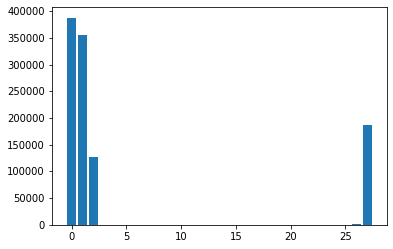

In [34]:
plt.bar(balance_df[balance_df["tick"] == balance_df["tick"].max()]["agent"], balance_df[balance_df["tick"] == balance_df["tick"].max()]["balance"])

In [35]:
balance_df[balance_df["tick"] == balance_df["tick"].max()].head(50)

,tick,agent,balance
5599972,199999,0,387584.253370
5599973,199999,1,354739.482740
5599974,199999,2,127471.263874
5599975,199999,3,4.586607
5599976,199999,4,1.150634
5599977,199999,5,2.248597
5599978,199999,6,3.083612
5599979,199999,7,3.385867
5599980,199999,8,6.686464
5599981,199999,9,4.584121


<AxesSubplot:>

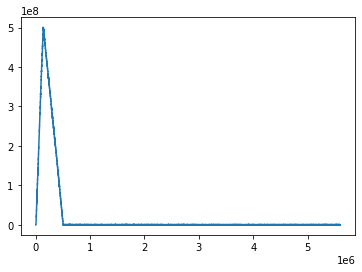

In [36]:
balance_df[balance_df["agent"] == 3]["balance"].plot()

# Inventory

In [37]:
columns = ["tick", "agent"] + list(map(lambda x: str(x), range(production_chain_df.shape[0])))
inventory_df = pd.read_csv("/tmp/inventory.log", sep="\t", header=None, names=columns)

In [38]:
production_chain_df

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
production_chain_df.iloc[:,-1][production_chain_df.iloc[:,-1] > 0]

18    14.0
19    35.0
20     6.0
Name: 27, dtype: float64

In [40]:
last_item_inputs = production_chain_df.iloc[:,-1][production_chain_df.iloc[:,-1] > 0].index

In [41]:
lti_df = inventory_df[inventory_df["tick"] == inventory_df["tick"].max()]

In [42]:
lti_df[lti_df["agent"].isin([production_chain_df.shape[0]-1])][map(lambda x: str(x), last_item_inputs)]

,18,19,20
5599999,172.0,35.0,2.0


In [43]:
ltb_df[ltb_df["agent"].isin([production_chain_df.shape[0]-1])]

,tick,agent,balance
5599999,199999,27,187304.019605


In [44]:
production_chain_df.iloc[:,last_item_inputs[2]][production_chain_df.iloc[:,last_item_inputs[2]] > 0]

10    4.0
11    4.0
16    7.0
Name: 20, dtype: float64

In [45]:
lii_inputs = production_chain_df.iloc[:,last_item_inputs[2]][production_chain_df.iloc[:,last_item_inputs[2]] > 0].index

In [46]:
lti_df[lti_df["agent"].isin([last_item_inputs[2]])][map(lambda x: str(x), lii_inputs)]

,10,11,16
5599992,338.0,1584.0,6.0


In [47]:
ltb_df[ltb_df["agent"].isin([last_item_inputs[2]])]

,tick,agent,balance
5599992,199999,20,379.283163


In [48]:
transaction_df[transaction_df["buyer"] == 21].groupby("product")["amount"].sum()

product
14     712593.0
17    1214096.0
Name: amount, dtype: float64

In [49]:
transaction_df[transaction_df["seller"] == 21].groupby("product")["amount"].sum()

product
21    43709.0
Name: amount, dtype: float64

In [50]:
transaction_df[transaction_df["buyer"] == 21]

,tick,seller,buyer,product,amount,price,value
36,7,17,21,17,13.0,636.279983,8.271640e+03
83,16,14,21,14,12.0,570.569698,6.846836e+03
95,20,14,21,14,15.0,663.079670,9.946195e+03
104,22,17,21,17,34.0,580.554046,1.973884e+04
115,24,14,21,14,18.0,830.578172,1.495041e+04
...,...,...,...,...,...,...,...
10916,1653,14,21,14,2222.0,1046.832227,2.326061e+06
10925,1655,17,21,17,217646.0,449.069643,9.773821e+07
19525,2975,14,21,14,231111.0,1085.593462,2.508926e+08
19534,2977,17,21,17,516744.0,643.860213,3.327109e+08


In [51]:
transaction_df[transaction_df["product"] == 8].groupby("buyer")["amount"].sum()

buyer
10     65383438.0
15    279005587.0
16    249128662.0
17     24941910.0
Name: amount, dtype: float64

In [52]:
liii_inputs = production_chain_df.iloc[:,lii_inputs[1]][production_chain_df.iloc[:,lii_inputs[1]] > 0].index
lti_df[lti_df["agent"].isin([lii_inputs[1]])][map(lambda x: str(x), liii_inputs)]

,5
5599983,1.0


In [53]:
ltb_df[ltb_df["agent"].isin([lii_inputs[1]])]

,tick,agent,balance
5599983,199999,11,4.336697


In [54]:
ltb_df[ltb_df["agent"].isin([17])]

,tick,agent,balance
5599989,199999,17,1.671706


In [55]:
inventory_df[(inventory_df["tick"] == inventory_df["tick"].max())&(inventory_df["6"]>0)].T

,5599978,5599987
tick,199999.0,199999.0
agent,6.0,15.0
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
5,0.0,0.0
6,715658015.0,8249.0
7,0.0,0.0


<AxesSubplot:>

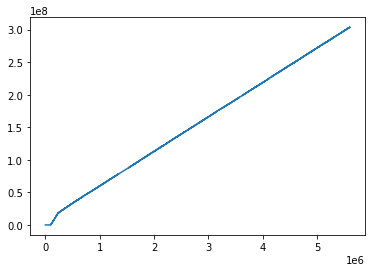

In [56]:
inventory_df[inventory_df["agent"]==1]["1"].plot()

In [57]:
inventory_df[(inventory_df["agent"]==1)&(inventory_df["1"]>10000)]

,tick,agent,0,1,2,3,4,5,6,7,...,18,19,20,21,22,23,24,25,26,27
2577,92,1,0.0,10871.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2633,94,1,0.0,10742.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2661,95,1,0.0,12701.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2689,96,1,0.0,12701.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2717,97,1,0.0,12701.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5599861,199995,1,0.0,303565048.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5599889,199996,1,0.0,303575048.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5599917,199997,1,0.0,303585048.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5599945,199998,1,0.0,303559244.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

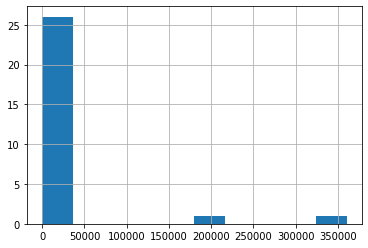

In [58]:
balance_df[balance_df["tick"] == 99999]["balance"].hist()

In [59]:
last_tick_inventory = inventory_df[inventory_df["tick"] == 99999]

In [60]:
balance_df[(balance_df["tick"] == 99999) & (balance_df["agent"] == 18)]

,tick,agent,balance
2799990,99999,18,163.575997


In [61]:
production_chain_df

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Profit Analysis

In [63]:
revenue = transaction_df.groupby("seller")["value"].sum()
costs = transaction_df.groupby("buyer")["value"].sum()

In [66]:
costs

buyer
5     5.166250e+09
6     1.247454e+10
7     8.195822e+09
8     1.305504e+10
9     1.530402e+09
10    3.213933e+09
11    1.404061e+09
12    6.878552e+08
13    3.008078e+08
14    6.809076e+08
15    1.835898e+10
16    1.501805e+10
17    7.574465e+08
18    7.389505e+09
19    1.086870e+10
20    1.955671e+10
21    1.310476e+09
22    2.070471e+08
23    4.015542e+08
24    6.878509e+08
25    4.068654e+08
26    2.964969e+09
27    3.704688e+10
Name: value, dtype: float64

In [68]:
revenue

seller
0     5.166250e+09
1     1.247454e+10
2     8.195822e+09
3     1.305504e+10
4     1.530402e+09
5     5.166249e+09
6     1.247454e+10
7     8.195820e+09
8     1.305504e+10
9     1.530401e+09
10    3.213910e+09
11    1.404052e+09
12    6.878509e+08
13    3.007864e+08
14    6.808598e+08
15    1.835897e+10
16    1.501799e+10
17    7.574220e+08
18    7.389370e+09
19    1.086862e+10
20    1.955590e+10
21    1.309000e+09
22    2.066144e+08
23    4.014344e+08
24    6.877748e+08
Name: value, dtype: float64

In [67]:
balance_df[balance_df["tick"] == balance_df["tick"].max()]

,tick,agent,balance
5599972,199999,0,387584.253370
5599973,199999,1,354739.482740
5599974,199999,2,127471.263874
5599975,199999,3,4.586607
5599976,199999,4,1.150634
5599977,199999,5,2.248597
5599978,199999,6,3.083612
5599979,199999,7,3.385867
5599980,199999,8,6.686464
5599981,199999,9,4.584121


In [70]:
inventory_df[inventory_df["tick"] == inventory_df["tick"].max()]

,tick,agent,0,1,2,3,4,5,6,7,...,18,19,20,21,22,23,24,25,26,27
5599972,199999,0,680169014.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5599973,199999,1,0.0,303569244.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5599974,199999,2,0.0,0.0,549657285.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5599975,199999,3,0.0,0.0,0.0,536275296.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5599976,199999,4,0.0,0.0,0.0,0.0,22921388.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5599977,199999,5,0.0,0.0,0.0,0.0,0.0,583443883.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5599978,199999,6,0.0,0.0,0.0,0.0,0.0,0.0,715658015.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5599979,199999,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,262846235.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5599980,199999,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5599981,199999,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
production_chain_df

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
